In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import (
    store_bin,
    project_dir,
    data_files,
    load_csv,
    load_bin,
    write_xlsx,
    load_txt
)

from pa_lib.data import (
    as_dtype,
    dtFactor,
    desc_col,
    lookup,
    clean_up_categoricals
)

from pa_lib.util import (
    collect,
    value,
    flatten,
    normalize_rows,
    list_items
)

from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data files

In [125]:
with project_dir("MediaFocus"):
    # List files in folder:
    display(data_files("*.feather"))
    
    # Branchen per KW über sie letzten 10 Jahre:
    br_kw     = load_bin("branchen_kw_10y.feather").astype({'Jahr': 'int64'})
    
    # Wie oben, aber unterhalb Branchen noch nach Produktgruppen aufgeteilt:
    br_pg_kw  = load_bin("branchen_pg_kw_10y.feather")
    
    
    br_wbt_kw = load_bin("branchen_wbt_kw.feather")

,size,mtime
name,,
branchen_kw_10y.feather,100.9 KB,31.10.19 15:28:44
branchen_pg_kw_10y.feather,553.2 KB,31.10.19 15:28:44
branchen_wbt_kw.feather,15.2 MB,31.10.19 15:28:44


18:17:15 [INFO] Started loading binary file ...
18:17:15 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_kw_10y.feather
18:17:15 [INFO] ... finished loading binary file in 0.0s (0.02s CPU)
18:17:15 [INFO] Started loading binary file ...
18:17:15 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_pg_kw_10y.feather
18:17:15 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)
18:17:15 [INFO] Started loading binary file ...
18:17:15 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_wbt_kw.feather
18:17:15 [INFO] ... finished loading binary file in 0.01s (0.02s CPU)


In [126]:
print(80*"#"+"\n")
print("br_kw")
display(br_kw.shape)
display(
    br_kw.sample(5)
)


print(80*"#"+"\n")
print("br_pg_kw")
display(br_pg_kw.shape)
display(
    br_pg_kw.sample(5)
)


print(80*"#"+"\n")
print("br_wbt_kw")
display(br_wbt_kw.shape)
display(
    br_wbt_kw.sample(5)
)
print(80*"#")

################################################################################

br_kw


(231, 55)

,Jahr,Branche,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
203,2018,PERSOENLICHER BEDARF,834341,1918943,1415895,1724819,1498080,1055181,800367,1193182,2780822,2443971,3599982,3566419,2758233,1036234,1241536,1793820,2320453,2365624,1962659,1247582,1761562,1334536,1056729,902767,1087966,1044392,811816,758493,877832,1014842,678977,645849,816683,949229,1463155,3174198,2707110,1719968,2309508,2208324,1827183,1711117,3740299,4335818,3585349,4572376,3880315,3655015,3317138,2385243,1766695,707353,0
50,2011,GETRAENKE,1492814,1552610,1022287,1814449,1657064,1835040,1537926,2010181,2368115,2096793,2398589,2386686,1936547,3445049,3341028,2870863,4290703,4111148,4286442,4301970,6253078,4694567,3688446,2934707,3511083,3852953,2879267,2271132,2732059,2502785,3263713,2342621,4504837,5237343,4673899,3059381,2621109,2861102,4235588,2889577,2098041,2189634,3203294,2722577,3138366,2560831,4312177,5551205,4144809,4296281,2791709,3385608,0
84,2013,"BAUEN, INDUSTRIE, EINRICHTUNG",5244307,4237752,3370243,4608626,3975047,3553100,4204997,5760871,5570359,7412446,8756213,6685389,7030363,6303697,7786618,7882594,6641468,6823232,6029367,5638414,4700178,5469806,4095989,5429349,4553044,6318898,3118392,2853106,3177719,3083639,3031393,2396770,4476162,3440594,5817103,4592318,6278150,6431860,8562065,7950569,7069054,5759421,8527502,7304756,6948119,5861609,4897884,5765279,4789327,5155697,3870875,5277003,0
91,2013,"FREIZEIT, GASTRONOMIE, TOURISMUS",5297066,6375876,6878781,6900236,6168101,4925531,4374742,4867482,6385472,4989153,5515629,6457697,4851819,5749404,4927834,4816293,5598244,5873078,4190191,5290647,4701207,5629224,5180770,4936110,6040585,5537945,4223752,2598033,3872796,4106402,3771421,3105228,3940259,4241967,7145438,5513021,4930479,4610714,4771311,5321088,3989047,4060604,5742348,6246579,3920851,4833098,4803462,6235603,5703418,4675652,3635942,3671105,0
82,2012,VERANSTALTUNGEN,2876702,4245533,4259739,3738502,4335515,3904863,3775183,4373062,6135824,5995394,5682534,5774702,5984324,5485419,4742981,6336989,6631870,6981104,5387801,5228229,5876604,6086912,5637417,5464973,5351298,5692339,5112925,4560181,3612287,3506196,3623054,3817870,5149911,5753931,7101511,5853753,5740617,6167375,6273513,6362977,4878454,5523269,6983001,6996224,6843976,5431854,6112660,8284383,6405954,5665246,4528028,2704417,0


################################################################################

br_pg_kw


(1309, 56)

,Jahr,Branche,Produktgruppe,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
1029,2017,NAHRUNGSMITTEL,BAECKEREI,157360,13842,85571,92191,159254,190828,136308,654974,746483,333801,789309,310906,135511,89057,29427,66143,133545,183401,187069,163435,333818,82496,166097,26498,70780,170468,66783,9645,57842,117176,0,206618,210880,275614,337312,457761,976828,1301652,1552283,554395,203972,313057,154827,314068,173681,390641,447661,530140,286034,368026,33280,42407,0
853,2016,DIGITAL + HAUSHALT,HAUSHALTSGERAETE,838146,999788,719540,678698,969411,805369,1501408,939852,1782422,2277880,945639,1419435,1714669,1762373,1165917,1185283,1419637,1557599,1266073,669500,1190813,690060,1177785,1035663,620337,673458,880100,616367,578172,439879,381500,308784,432234,608122,1553874,1850555,1119315,2125177,1988621,1187684,1525727,1519101,1860891,1914491,1096628,766083,2349878,3892566,2914022,2151600,1401958,454351,254204
388,2012,FAHRZEUGE,PKW (GEBRAUCHT),14116,407762,312615,130106,29328,148875,194882,49552,26479,61876,69555,120331,44577,49542,20249,46539,8887,97589,110786,50846,30652,30393,7123,21685,14891,28222,11880,30539,20132,18284,9199,7783,7852,31809,8097,20916,15664,75184,42675,51116,6971,25113,5944,35315,15826,58757,41315,48156,15751,21700,28581,10080,0
1235,2019,GETRAENKE,"KAFFEE, TEE, KAKAO",146702,90728,656398,196840,722831,375820,803620,237634,588593,651447,810013,1178971,1050359,988945,528313,206278,668419,356039,979571,1326506,984427,881392,521887,350082,625776,883170,633783,236335,364704,484654,520961,467032,271833,323559,1103084,1192101,894932,748300,793200,186695,0,0,0,0,0,0,0,0,0,0,0,0,0
82,2009,NAHRUNGSMITTEL,SCHOKOLADE + SUESSWAREN,90929,218236,541007,821487,1793922,1552233,1757984,1133336,1806488,1409032,922104,1103336,1904998,2312879,1467596,1266639,985139,2032213,1567858,835645,868609,447676,1645972,658512,1081795,725623,663810,104999,323438,322829,60976,251724,409395,620245,980085,1348213,1127888,1118974,1557989,2242319,2069406,2774953,2278143,3970095,3365763,2388831,2461290,2954114,3082767,4035352,2970423,1243196,170955


################################################################################

br_wbt_kw


(35471, 55)

,Branche,Werbungtreibender,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
25705,INITIATIVEN + KAMPAGNEN,LAUSANNE REGION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6584,4364,10695,2313,0,0,3841,0,0,0,0,0,0
17812,FAHRZEUGE,CAMADA CICLI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,990,990,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27682,MEDIEN,ABZ VERLAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,660,0,0,0,0,0,0,0,0,0,0
13516,DIENSTLEISTUNG,QS QUACQUARELLI SYMONDS,0,0,0,0,4000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3968,0,0,0,0,0,0,0,0,0,0,0,0,0
11255,DIENSTLEISTUNG,HAYS SCHWEIZ AG,0,0,0,0,0,0,0,0,0,3900,5096,25004,0,0,9700,10278,0,5328,5096,3900,0,0,4950,5800,0,0,0,3900,0,0,0,0,5096,0,5800,4950,0,0,0,3900,5096,0,5328,5328,4950,0,0,0,6164,5800,0,0,0


################################################################################


# Find patterns

In [127]:
from pa_lib.data  import calc_col_partitioned

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [129]:
len(set(br_kw.loc[:,"Branche"]))

21

In [131]:
kw_columns = list(br_kw.columns)[2:]
br_kw.loc[:,"Brutto_Jahr"] = br_kw.loc[:,kw_columns].sum(axis="columns")

In [132]:
#kw_columns

In [133]:
br_kw.loc[:, ["Branche", "Jahr", "Brutto_Jahr"]].sort_values(["Branche", "Jahr"], ascending=[True, True]).head(12)

,Branche,Jahr,Brutto_Jahr
0,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,225372271
21,"BAUEN, INDUSTRIE, EINRICHTUNG",2010,260734554
42,"BAUEN, INDUSTRIE, EINRICHTUNG",2011,269037451
63,"BAUEN, INDUSTRIE, EINRICHTUNG",2012,264844857
84,"BAUEN, INDUSTRIE, EINRICHTUNG",2013,284518733
105,"BAUEN, INDUSTRIE, EINRICHTUNG",2014,286136196
126,"BAUEN, INDUSTRIE, EINRICHTUNG",2015,278792600
147,"BAUEN, INDUSTRIE, EINRICHTUNG",2016,261621736
168,"BAUEN, INDUSTRIE, EINRICHTUNG",2017,237990117
189,"BAUEN, INDUSTRIE, EINRICHTUNG",2018,234209813


In [134]:
branchen_liste = list(set(br_kw.loc[:,"Branche"]))
branchen_liste[0:7]

['KOSMETIK + KOERPERPFLEGE',
 'FREIZEIT, GASTRONOMIE, TOURISMUS',
 'PERSOENLICHER BEDARF',
 'FAHRZEUGE',
 'ENERGIE',
 'TELEKOMMUNIKATION',
 'DIGITAL + HAUSHALT']

In [135]:
br_kw.head(5)

,Jahr,Branche,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53,Brutto_Jahr
0,2009,"BAUEN, INDUSTRIE, EINRICHTUNG",1475891,2919457,2920115,3320761,3561250,3471169,3354064,4276107,3900002,4154680,4208414,6213296,6122367,6618858,4397194,4491488,5116467,5778062,5162234,4880535,4358518,4717198,4189679,3021469,4171929,4183769,3119433,1940075,1646845,2273324,1984416,2102742,3061546,3935922,4035648,4881130,4160343,5478326,6376138,6329324,7408536,5914194,6954294,5688355,5948818,4032135,4494710,6011579,4402333,3673181,3423699,2827843,2282409,225372271
1,2009,DETAILHANDEL,3809664,6759038,7012067,4266813,7261881,4658060,5077131,4920776,6491423,4792526,5289118,6091374,5798821,6504253,6028183,6392650,6909910,7359485,6401493,4710896,6713022,5728434,7140533,4932778,5065366,5518464,5928008,4730800,5434855,5365445,7463936,5622002,4733339,4377539,5352404,6226435,5685182,5442993,7689321,7482595,8353337,6410230,6514572,7487712,6792942,6248210,6417471,7663644,13043263,8764256,9209719,5787285,5363664,331225318
2,2009,DIENSTLEISTUNG,1868443,3192781,3280312,3321827,4425565,2666862,2740178,2825309,4349313,3515669,3262267,3637447,4327615,4261216,2174448,1902074,3059587,3900073,2976750,2843062,2566073,3172513,3956265,2214384,2690336,2132785,2869767,1890526,1522255,1628570,2337891,1662102,2277144,2952682,3954983,5793615,3174977,3392314,3131438,4235911,2407336,2717024,3528841,5926138,3683616,3394443,3119892,3094972,4798310,2887974,2784814,1925110,1220761,163576560
3,2009,DIGITAL + HAUSHALT,1956595,2692179,1629850,1307705,3097427,1646054,2369871,1895251,3637077,3213532,3863809,3325529,4193534,3889007,3814764,3486740,3837741,5922905,4382198,4037106,3925978,3959128,3772512,2506045,3276792,3173562,4416721,2642339,2346321,2500380,2634203,2781721,1337518,2983597,2825824,4072282,3694126,3662837,4053842,5382511,3526990,4385593,5807135,7542123,5213853,5147001,6265057,8053454,11279112,8126797,8429549,4342685,1915365,210181827
4,2009,ENERGIE,102356,314912,218588,150316,509230,377422,344115,303906,777541,785380,557773,486412,505658,581138,491906,622172,670251,721583,712721,741077,855291,871819,869606,605643,886845,647619,516485,447514,290365,218911,211840,222443,239309,300501,512303,959665,913376,705597,645007,640879,420967,506447,982016,829299,935573,815373,631363,640385,563422,538186,580621,314513,99561,29393201


In [137]:
def lineplot_branches(select_branches):
    branch_select = br_kw.loc[:,"Branche"].isin(select_branches)
    plt.figure(
        figsize=(15, 8)
    )

    sns.lineplot(
        data=br_kw.loc[branch_select,:].pipe(clean_up_categoricals),
        x="Jahr",
        y="Brutto_Jahr",
        hue="Branche",
        dashes=True,
        markers=True,
        ci=0.5,
    )

    # Put the legend out of the figure
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.
    )
    plt.show()



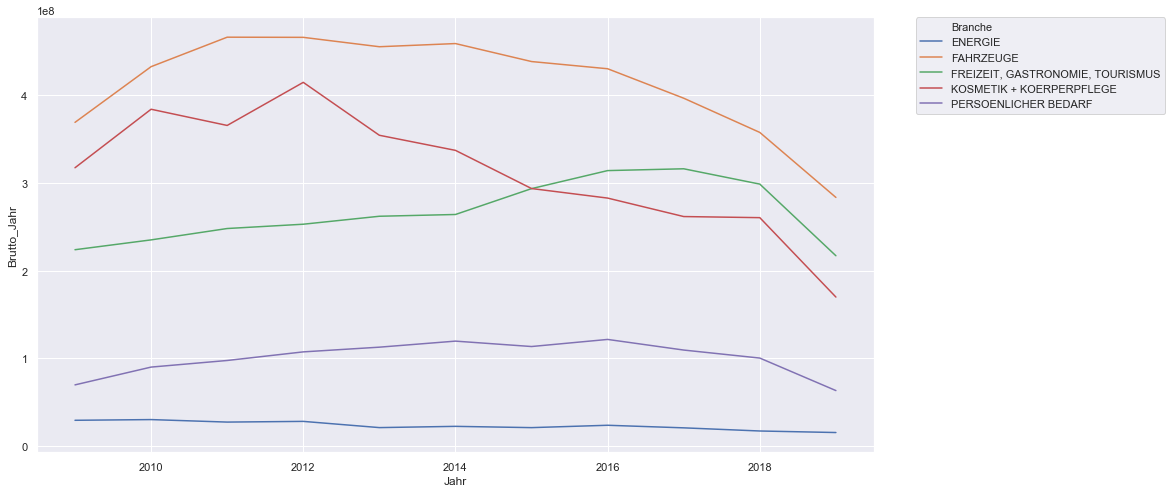

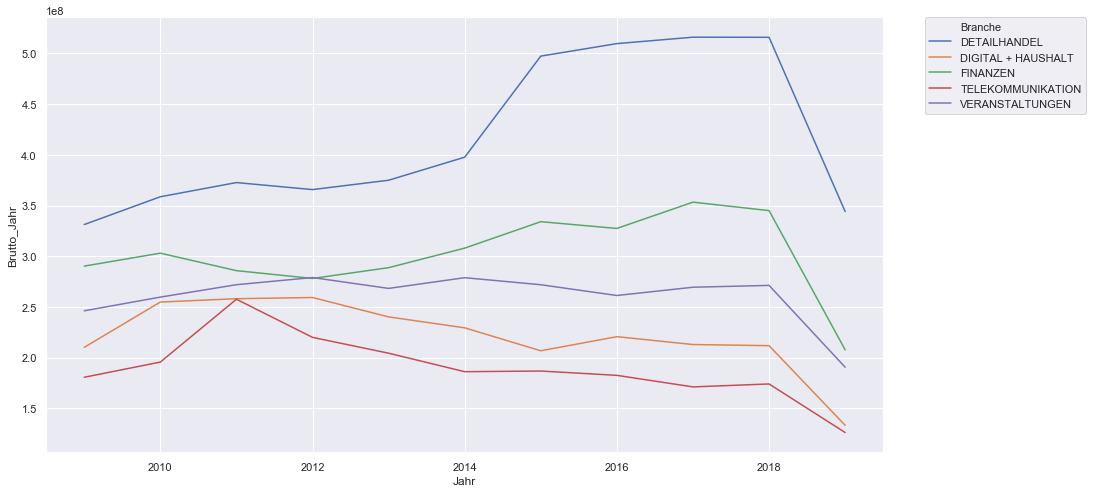

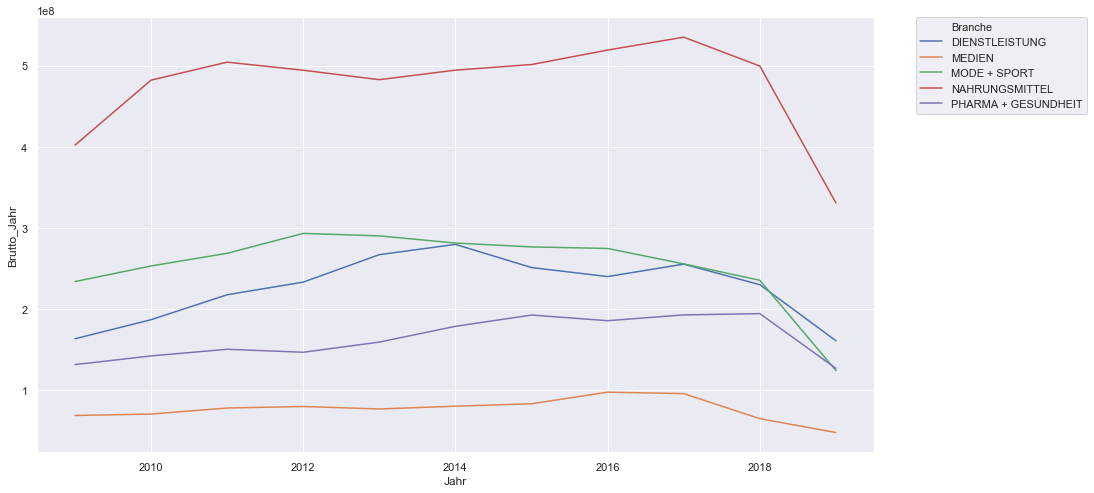

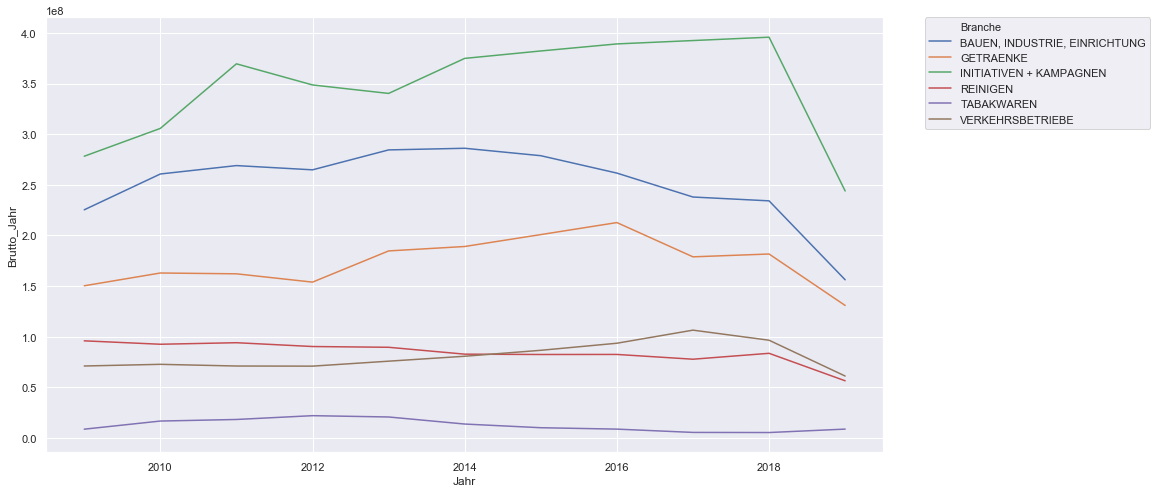

In [138]:
lineplot_branches(select_branches=branchen_liste[0:5])
lineplot_branches(select_branches=branchen_liste[5:10])
lineplot_branches(select_branches=branchen_liste[10:15])
lineplot_branches(select_branches=branchen_liste[15:])


In [140]:
#br_kw = br_kw.astype({'Jahr': 'int64'})

row_without_2019 = (br_kw.loc[:,"Jahr"] < 2019)

br_kw_without_2019 = calc_col_partitioned(
    df=br_kw.loc[row_without_2019,:],
    col="Brutto_Relativ",
    #fun="max",
    fun=lambda s: (s - s.min()) / (s.max() - s.min()),
    on="Brutto_Jahr",
    part_by="Branche")
 #.loc[:,["Branche", "Jahr", "Brutto", "Brutto_Relativ"]]
 #.sort_values(["Branche", "Jahr"], ascending=[True, True]))

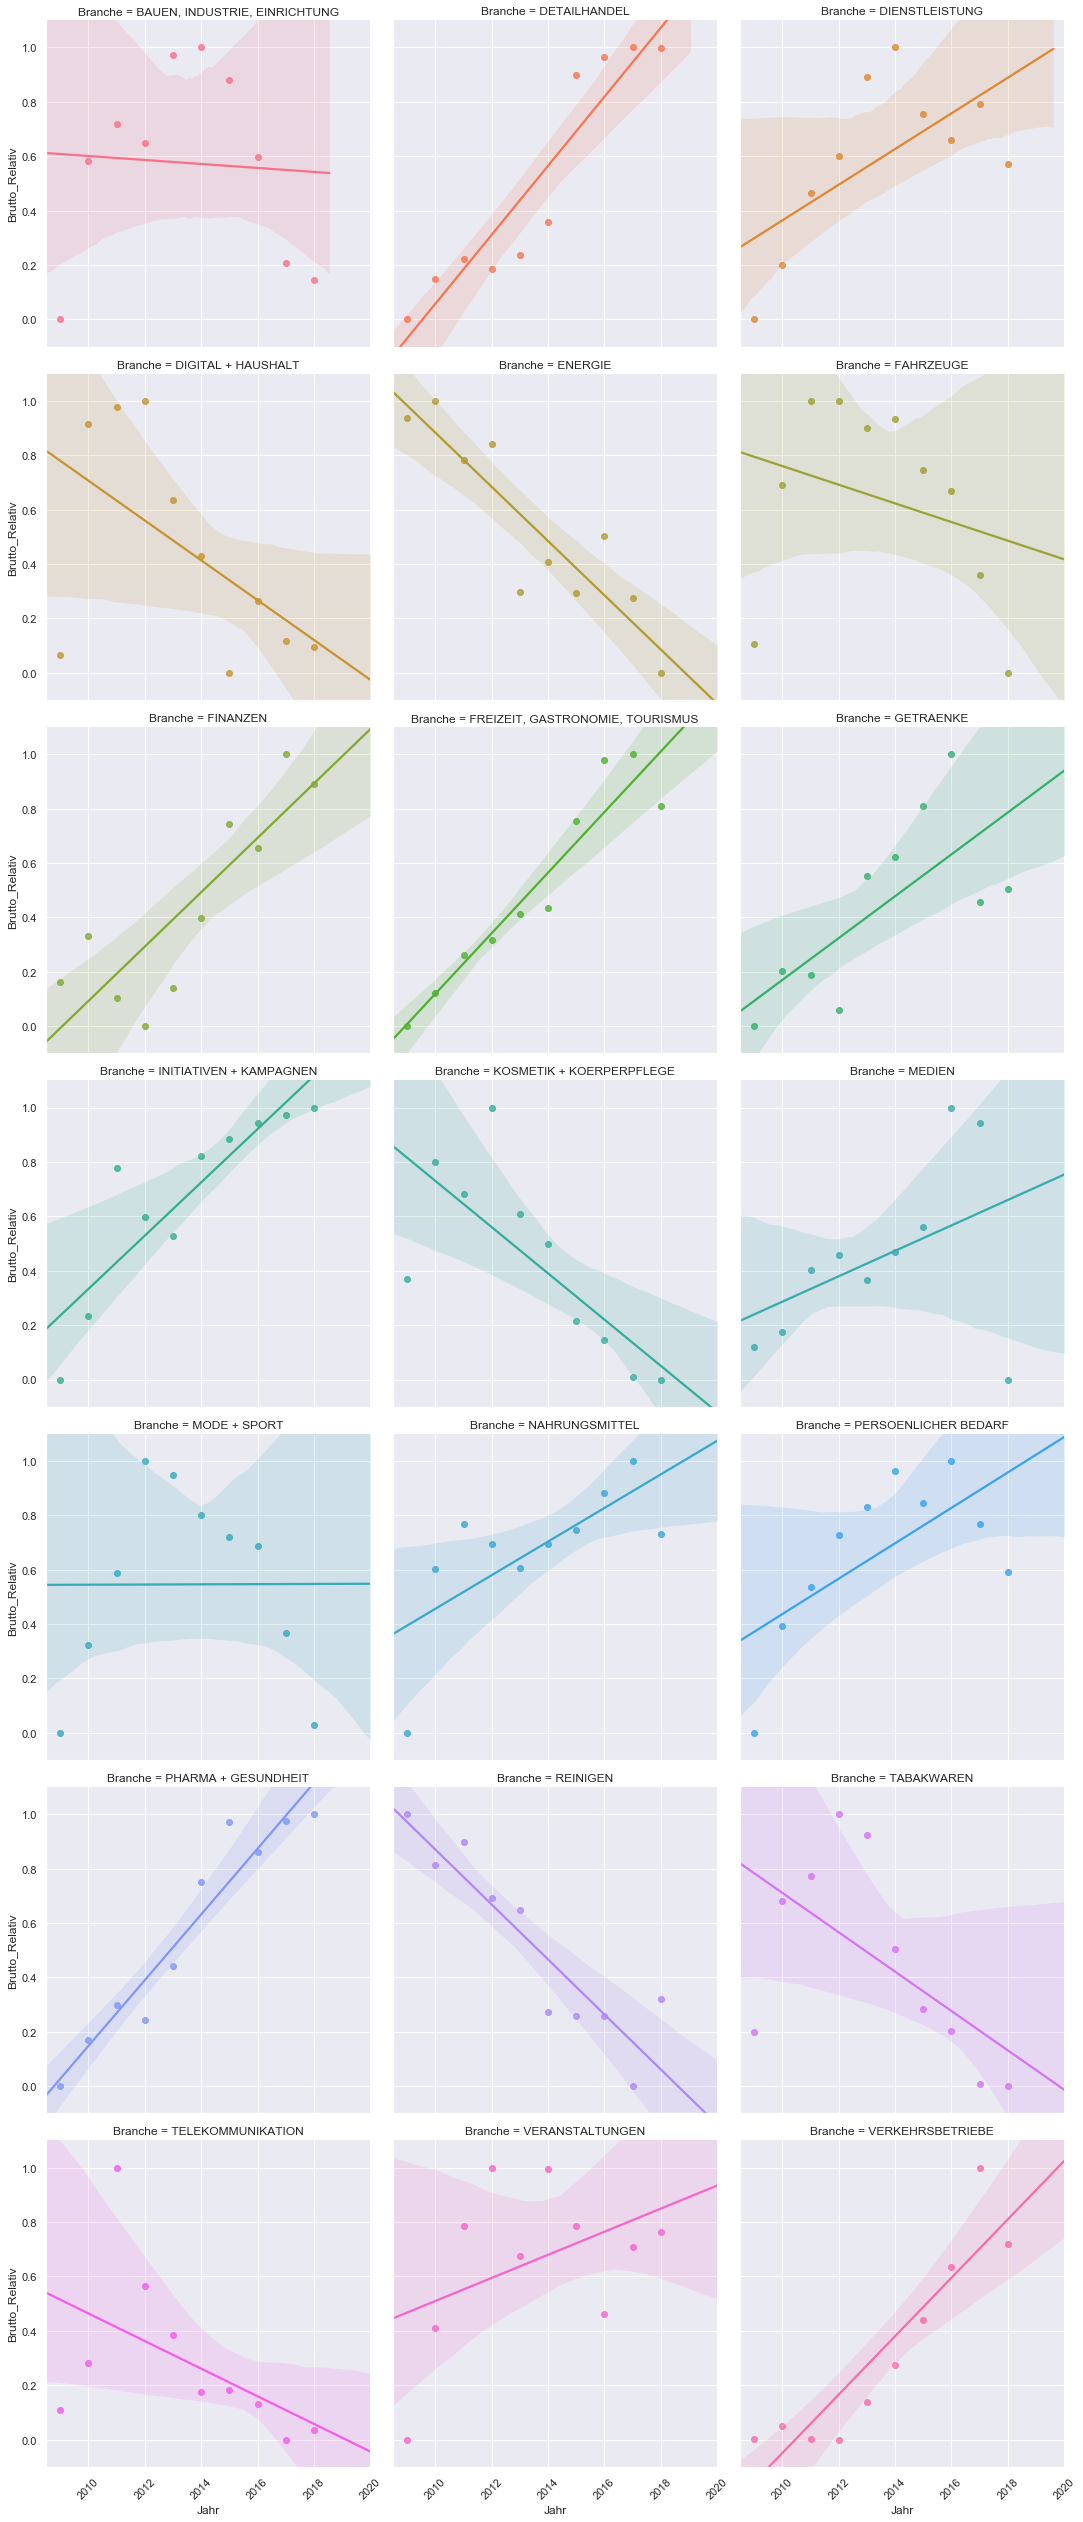

In [142]:
#br_kw
g = sns.lmplot(
    x        = "Jahr",
    y        = "Brutto_Relativ",
    col      = "Branche",
    hue      = "Branche", # kinda useless, but nice to look at!
    data     = br_kw_without_2019,
    col_wrap = 3, # How many plots per row
    height   = 5,
    order    = 1, # polynomial regression of order, best for 1 or 2
    #lowess = True,
    #ci       = 95,
).set(xlim=(2008.5, 2020),ylim=(-0.1,1.1))

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

## Melting `br_kw`

In [143]:
from pa_lib.util import iso_to_datetime

In [144]:
################################################################################
## Put all KW_XY folders underneath each other:

calender_columns = [col for col in br_kw.columns if col.startswith("KW_")]

container_df = (
    pd.melt(
        br_kw,
        id_vars    = ["Branche","Jahr"],
        value_vars = calender_columns,
        var_name   = "KW",
        value_name = "Brutto"
    )
)

################################################################################
## Create Datum column:

years_temp = container_df.loc[:,"Jahr"]
kws_temp   = container_df.loc[:,"KW"].map(lambda x : int(x[3:5]))

date_series = (
    years_temp
        .combine(
            kws_temp,
            func = lambda year, kw: iso_to_datetime(year=year, kw=kw, day=1)
        )
)

container_df.loc[:,"Datum"] = date_series

br_kw_datum = (
    container_df
        #.loc[:,["Branche","Datum","Brutto"]]
        .sort_values(["Branche","Datum"])
)
################################################################################
## Turn Datum column into Integer, so lmplot can handle it:

Datum_Rel = (
    (br_kw_datum.Datum - br_kw_datum.Datum.min())
    .astype("int64")//86400000000000   # Gives days since global min
)
br_kw_datum.loc[:,"Datum_Relativ"] = Datum_Rel # integer series

################################################################################
## Create Brutto relative to min and max of Branche:

br_kw_datum = calc_col_partitioned(
    df      = br_kw_datum,
    col     = "Brutto_Relativ",
    fun     = lambda s: (s - s.min()) / (s.max() - s.min()),
    on      = "Brutto",
    part_by = "Branche")

################################################################################
## Show me the result:

br_kw_datum.head()

,Branche,Jahr,KW,Brutto,Datum,Datum_Relativ,Brutto_Relativ
0,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_01,1475891,2008-12-29,0,0.152056
231,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_02,2919457,2009-01-05,7,0.300782
462,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_03,2920115,2009-01-12,14,0.300850
693,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_04,3320761,2009-01-19,21,0.342127
924,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_05,3561250,2009-01-26,28,0.366904


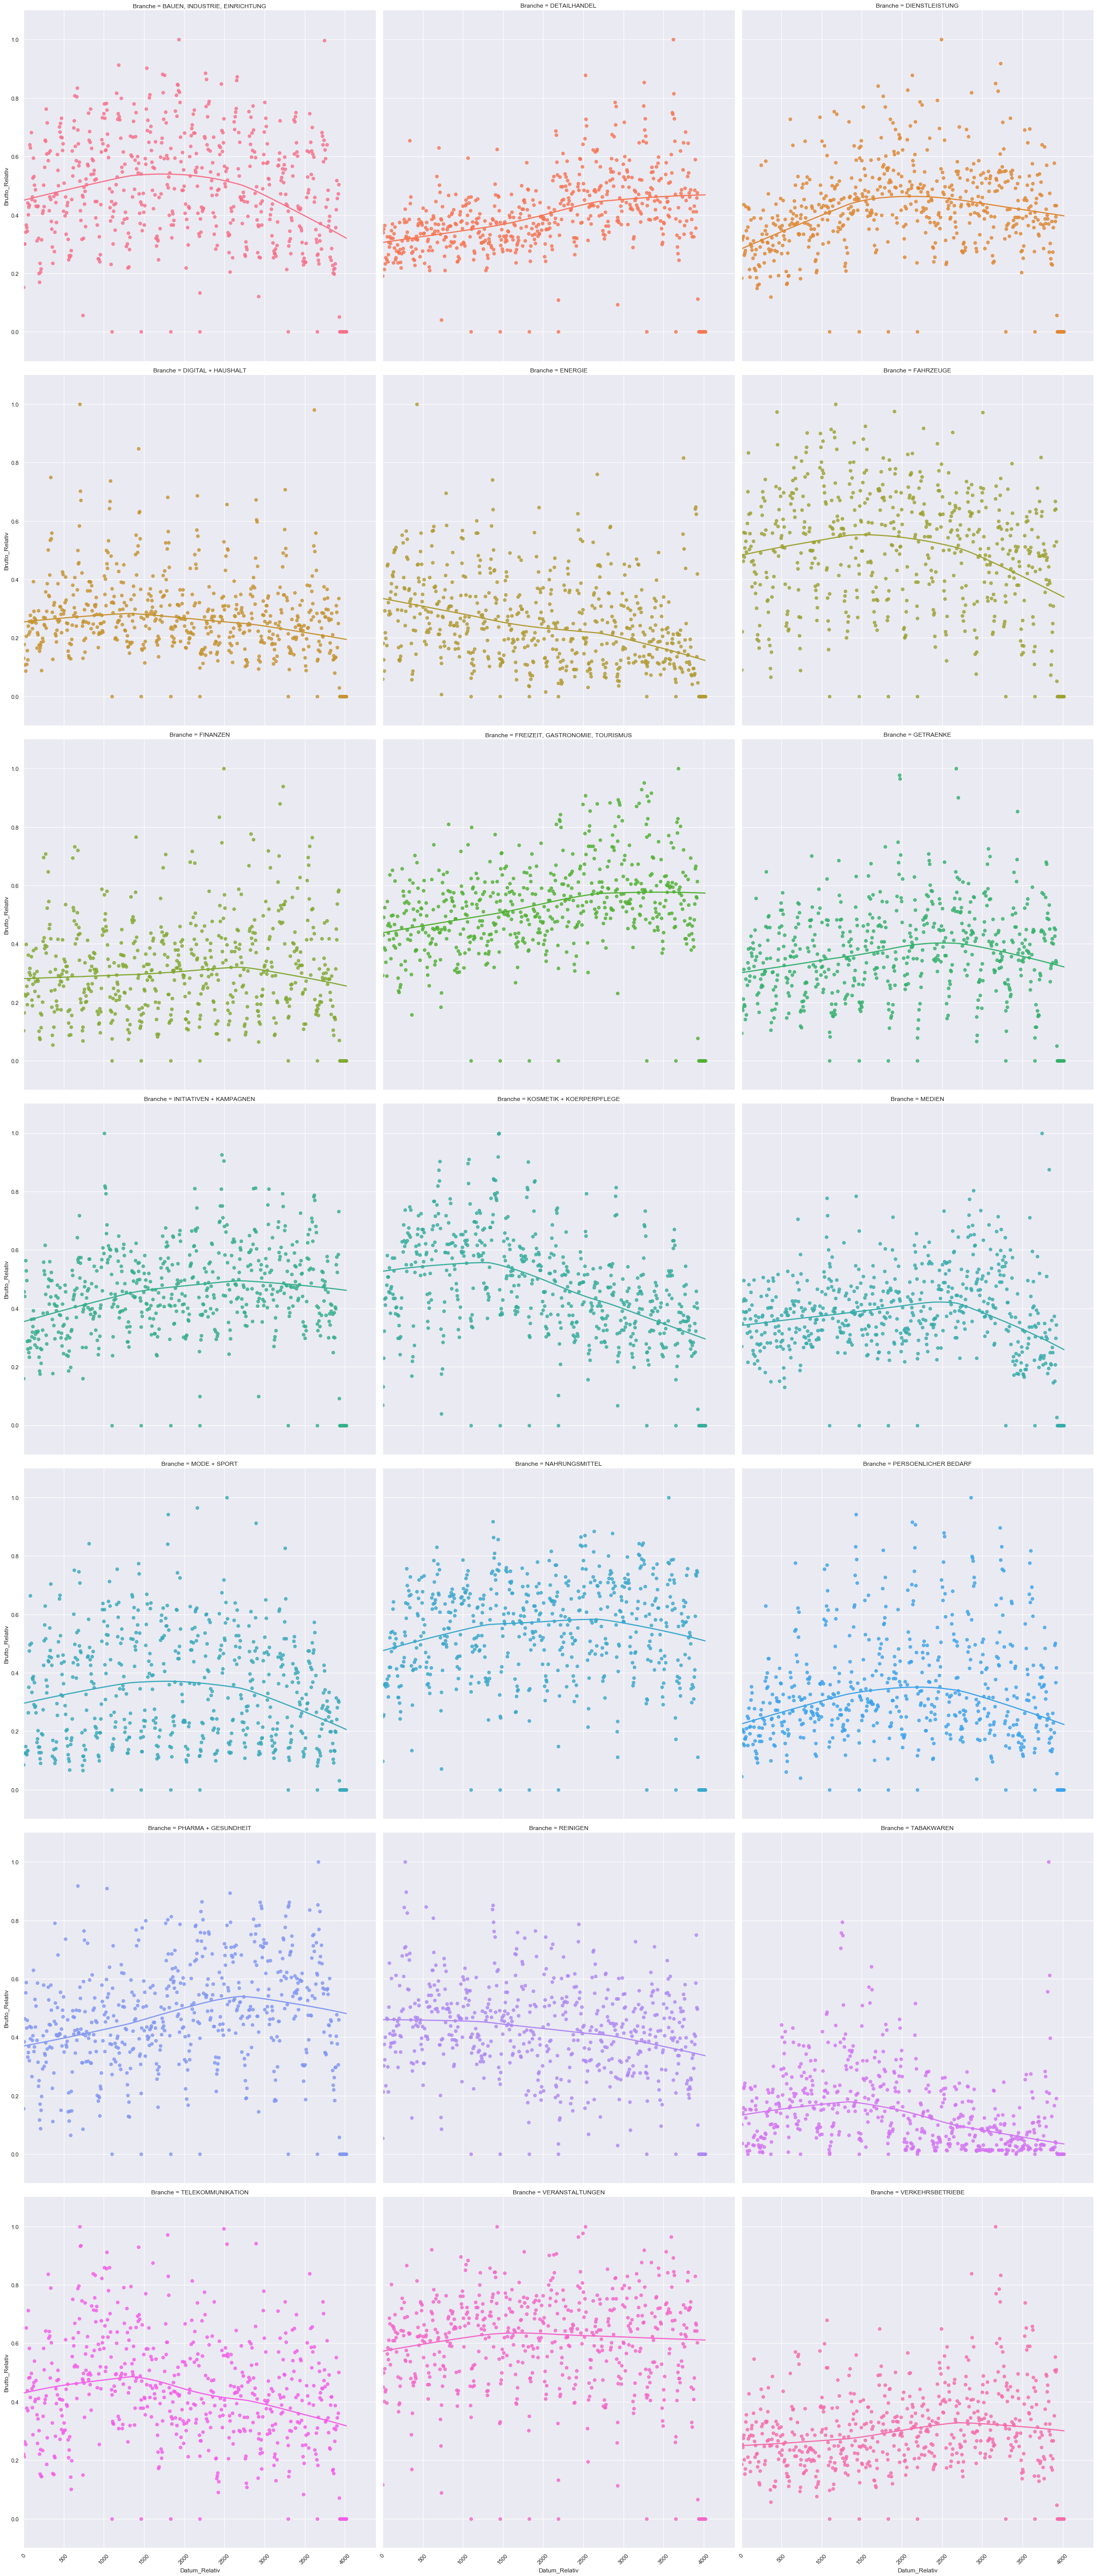

In [145]:
g = sns.lmplot(
    x        = "Datum_Relativ",
    y        = "Brutto_Relativ",
    col      = "Branche",
    hue      = "Branche", # kinda useless, but nice to look at!
    data     = br_kw_datum,
    col_wrap = 3, # How many plots per row
    height   = 10,
    #order    = 3, # polynomial regression of order, best for 1 or 2
    lowess  = True,
    #ci       = 95,
).set(xlim=(br_kw_datum.Datum_Relativ.min(), br_kw_datum.Datum_Relativ.max()+368),ylim=(-.1,1.1))

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)


***
> 1. Regression is not good enough for fitting
2. Periodic effects (yearls, seasonal, holidays) are not taken into account. The plots look messy.
***

## `fbprophet`

- https://facebook.github.io/prophet/
- https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

In [146]:
# conda install -c conda-forge fbprophet 

from fbprophet import Prophet
import holidays

CH_holidays = holidays.CH(prov=kantone)

In [147]:
from fbprophet.plot import add_changepoints_to_plot

In [148]:
branchen_liste

['KOSMETIK + KOERPERPFLEGE',
 'FREIZEIT, GASTRONOMIE, TOURISMUS',
 'PERSOENLICHER BEDARF',
 'FAHRZEUGE',
 'ENERGIE',
 'TELEKOMMUNIKATION',
 'DIGITAL + HAUSHALT',
 'VERANSTALTUNGEN',
 'DETAILHANDEL',
 'FINANZEN',
 'MEDIEN',
 'DIENSTLEISTUNG',
 'NAHRUNGSMITTEL',
 'MODE + SPORT',
 'PHARMA + GESUNDHEIT',
 'GETRAENKE',
 'TABAKWAREN',
 'BAUEN, INDUSTRIE, EINRICHTUNG',
 'VERKEHRSBETRIEBE',
 'INITIATIVEN + KAMPAGNEN',
 'REINIGEN']

In [149]:
branchen_liste[0]

'KOSMETIK + KOERPERPFLEGE'

In [150]:
ch_holidays = pd.DataFrame(holidays.CH(years = list(range(2005,2021)), prov = kantone,state= kantone).items(), columns=["ds","holiday"] )

In [151]:
branche_xyz = branchen_liste[0]
latest_date = iso_to_datetime(year=2019,kw=20, day=1)

print(80*"#")
print(f"Branche: {branche_xyz}")
select_branche = (br_kw_datum.Branche == branche_xyz)
before_maxdate = (br_kw_datum.Datum < latest_date)


df = (
    br_kw_datum
        .loc[select_branche & before_maxdate,["Datum","Brutto"]]
        .rename(columns={"Datum": "ds", "Brutto": "y"}) # Was anderes schluckt er nicht
)

print(80*"#")
print("df.head(10)")
display(df.head(10))

ch_holidays = (
    pd.DataFrame(
        holidays.CH(years = list(range(2005,2021))).items(),
        columns=["ds","holiday"]
    )
)

m = Prophet(
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays= ch_holidays,
)


print(80*"#")
print("m.fit(df)")
m.fit(df)

future = m.make_future_dataframe(periods=365)
#future.tail()

forecast = m.predict(future)
print(80*"#")
print("forecast.tail()")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

################################################################################
Branche: KOSMETIK + KOERPERPFLEGE
################################################################################
df.head(10)


,ds,y
10,2008-12-29,869421
241,2009-01-05,1669550
472,2009-01-12,2889899
703,2009-01-19,4070121
934,2009-01-26,5449642
1165,2009-02-02,5186490
1396,2009-02-09,5498660
1627,2009-02-16,6044927
1858,2009-02-23,7325804
2089,2009-03-02,6397871


################################################################################
m.fit(df)


C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



################################################################################
forecast.tail()


,ds,yhat,yhat_lower,yhat_upper
909,2020-05-01,4.968525e+06,3.631649e+06,6.211788e+06
910,2020-05-02,4.970787e+06,3.689961e+06,6.318567e+06
911,2020-05-03,4.970218e+06,3.723864e+06,6.285254e+06
912,2020-05-04,4.966431e+06,3.679571e+06,6.249370e+06
913,2020-05-05,4.959094e+06,3.590358e+06,6.249211e+06


In [152]:
type(fig1)

matplotlib.figure.Figure

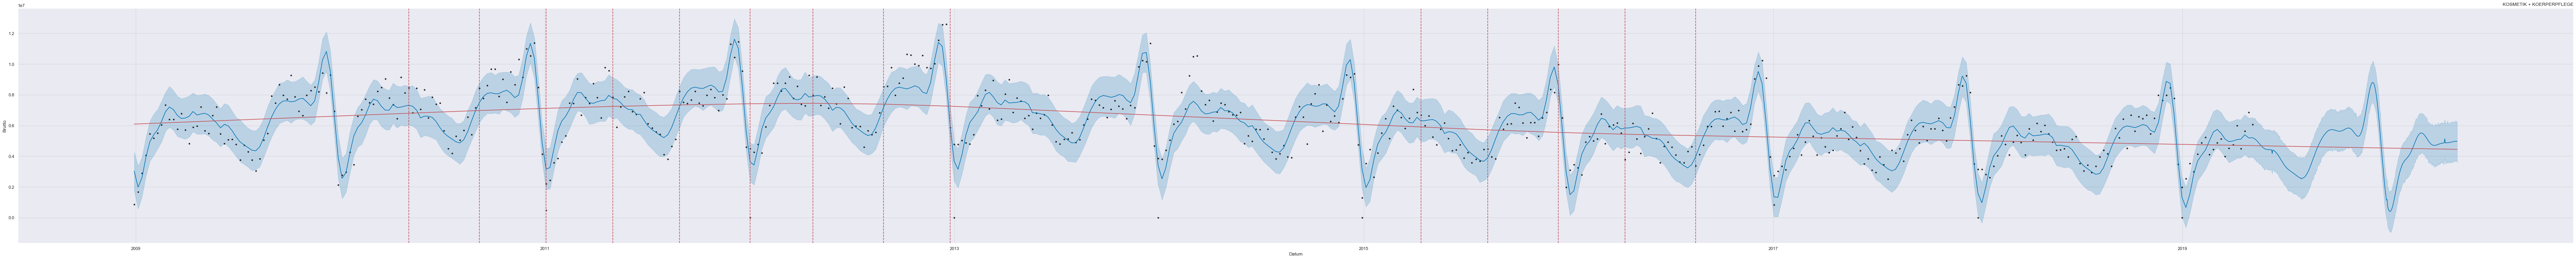

In [153]:
fig1 = (
    m.plot(
        forecast,
        xlabel = "Datum",
        ylabel = "Brutto",
    )
)
plt.title(branche_xyz, loc="right",)
fig1.set_size_inches(100,10)

a = add_changepoints_to_plot(fig1.gca(), m, forecast)

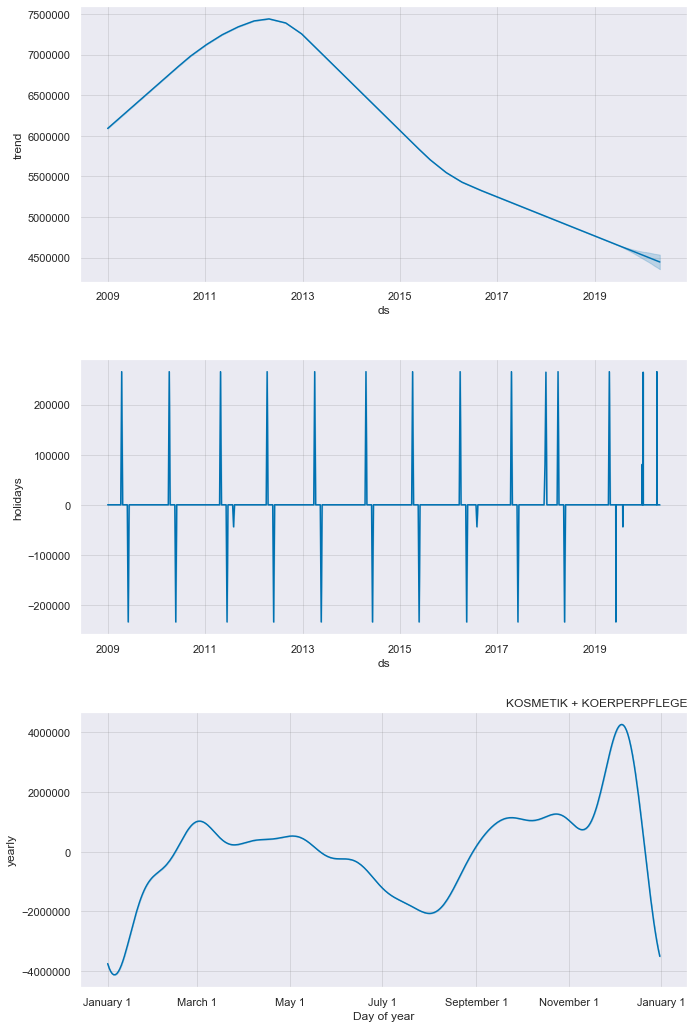

In [154]:
fig2 = m.plot_components(forecast)
plt.title(branche_xyz, loc="right")
fig2.set_size_inches(10,15)


# Scribbles